In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import data_manager.utils as sbtu
import data_manager.scanner as scanner
import regime as sur
import scripts
# import src.floor_ceiling_regime

In [2]:
(
    _price_data,
    _bench,
    _strategy_overview,
    _peak_table,
    _entry_table,
    _strategy_lookup
) = scripts.load_data_package()
_relative_rebased = sbtu.PriceGlob(_price_data).relative_rebased(_bench.close)
_price_data_by_symbol = sbtu.PriceGlob(_price_data).swap_level()

<AxesSubplot:>

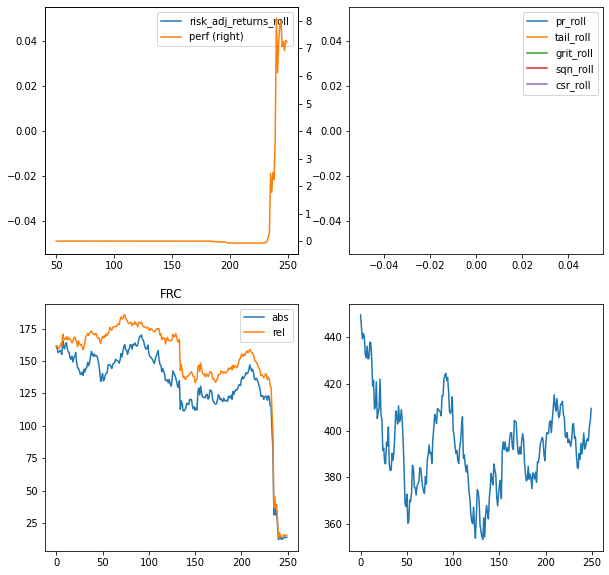

In [3]:
symbol = 'FRC'
_strat_data = _strategy_lookup[symbol]
_stats = _strategy_lookup[symbol].stat_historical
_, axs = plt.subplots(2, 2)
_stats[['risk_adj_returns_roll', 'perf']].plot(secondary_y=['perf'], ax=axs[0, 0], figsize=[10,10])
plot_copy = _stats[['pr_roll', 'tail_roll', 'grit_roll', 'sqn_roll', 'csr_roll']]
plot_copy.plot(ax=axs[0, 1])

def get_abs_rel(_s):
    sd = _price_data_by_symbol.data[_s]
    rel = sur.simple_relative(sd, _bench.close).close
    return pd.DataFrame(
        data={
            'abs': sd.close,
            'rel': rel
        }
    )

_symbol_data = _price_data_by_symbol.data[symbol]
get_abs_rel(symbol).plot(title=symbol, ax=axs[1, 0])
_bench.close.plot(ax=axs[1, 1])

<AxesSubplot:xlabel='entry'>

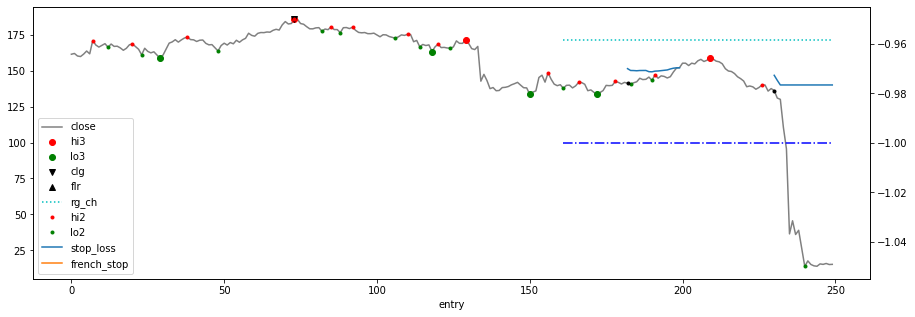

In [4]:
epd = _strategy_lookup[symbol].enhanced_price_data.copy()
epd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price
_sl = _strategy_lookup[symbol].stop_loss_series
_sl = _sl.loc[~_sl.index.duplicated(keep='first')]
epd['stop_loss'] = _sl
# epd['base_close'] = _symbol_data.close
scanner.enhanced_price_data_plot(epd)
_en_cpy = _entry_table.loc[_entry_table.symbol == symbol].copy()
_en_cpy.index = _en_cpy.entry
_en_cpy.en_px.plot(style='k.')

In [5]:

_pt = _strategy_lookup[symbol].peak_table.copy()
# _pt = pda.PeakTable(_pt)
# _pt = _pt.unpivot(_symbol_data.index)
# _pt = _pt.loc[~_pt.index.duplicated(keep='first')]
def filter_duplicates(_sw):
    return _sw.loc[~_sw.index.duplicated(keep='first')]

_shi_px = _pt.loc[(_pt.type == -1)].set_index('end')
_slo_px = _pt.loc[(_pt.type == 1)].set_index('end')
_shis = []
_slos = []
for i in range(1, 5):
    _shis.append(
        _shi_px.loc[(_shi_px.lvl == i)]
    )
    _shis[i-1] = filter_duplicates(_shis[i-1])
    _slos.append(
        _slo_px.loc[(_slo_px.lvl == i)]
    )
    _slos[i-1] = filter_duplicates(_slos[i-1])
    epd[f'hi{i}_lag'] = _shis[i-1].en_px
    epd[f'lo{i}_lag'] = _slos[i-1].en_px


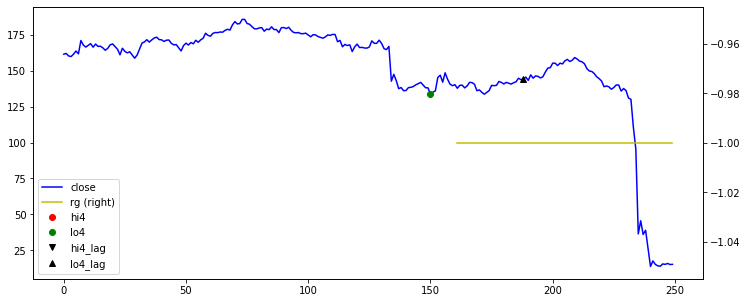

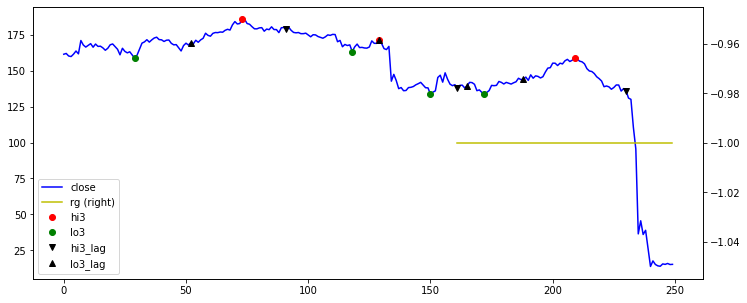

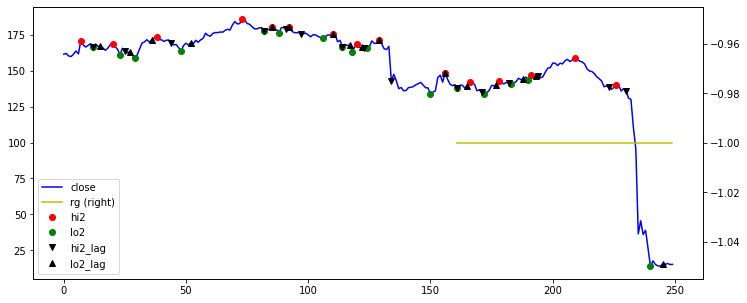

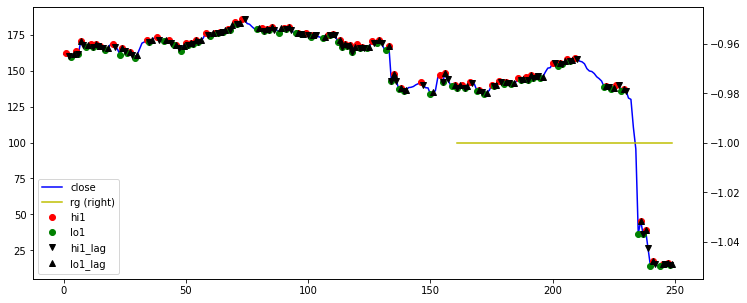

In [6]:


_epd_plt = epd[['close', 'hi2', 'lo2', 'hi3', 'lo3', 'rg']]

def plot(lvl):
    epd[[
        'close', 'rg',
        f'hi{lvl}', f'lo{lvl}',
        f'hi{lvl}_lag', f'lo{lvl}_lag',
    ]].plot(style=['b', 'y', 'ro', 'go', 'kv', 'k^'], figsize=[12, 5], secondary_y='rg')

plot(4)
plot(3)
plot(2)
plot(1)

<AxesSubplot:title={'center':'lvl3 lag'}, ylabel='Frequency'>

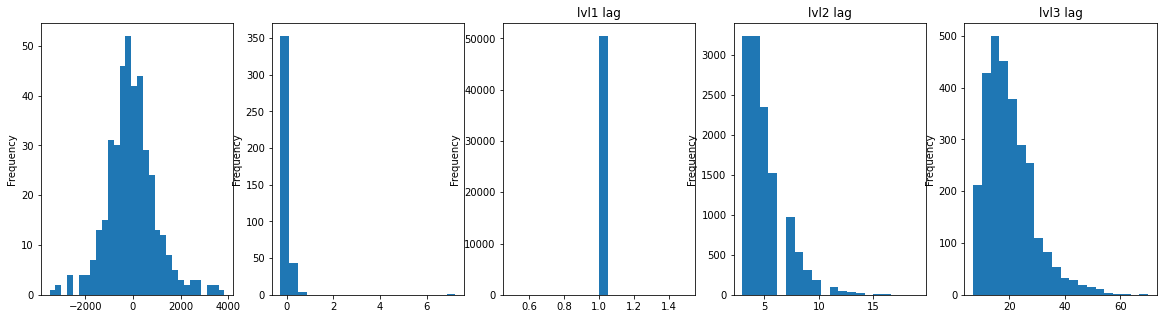

In [7]:
_, axs = plt.subplots(1, 5)
_strategy_overview.weight_total.plot.hist(bins=30, ax=axs[0], figsize=(20, 5))
_strategy_overview.perf.plot.hist(bins=20, ax=axs[1])

_peak_table['peak_lag'] = _peak_table.end - _peak_table.start
partial_exit_lag = _entry_table.partial_exit_date - _entry_table.entry
_entry_table['partial_exit_lag'] = partial_exit_lag

_peak_table.loc[_peak_table.lvl == 1, 'peak_lag'].plot.hist(bins=20, ax=axs[2], title='lvl1 lag')
_peak_table.loc[_peak_table.lvl == 2, 'peak_lag'].plot.hist(bins=20, ax=axs[3], title='lvl2 lag')
_peak_table.loc[_peak_table.lvl == 3, 'peak_lag'].plot.hist(bins=20, ax=axs[4], title='lvl3 lag')

,entry,en_px,st_px,dir,trail_stop,fixed_stop,fixed_stop_price,r_pct,target_price,partial_exit_date,...,partial_exit,risk,shares,partial_profit,rem_profit,partial_total,no_partial_total,my_total,total,partial_exit_lag
0,124.0,140.135738,140.501544,-1.0,120.0,120.0,140.501544,-0.002610,139.587028,126.0,...,115.620003,-0.007500,-214.0,-727.040390,-889.920044,-1616.960434,-2645.040131,-1616.960434,-1616.960434,2.0
1,217.0,124.800639,130.138767,-1.0,209.0,209.0,130.138767,-0.042773,116.793447,242.0,...,101.540001,-0.005303,-29.0,240.729965,90.999985,331.729950,263.899956,331.729950,-1285.230484,25.0
0,229.0,90.428446,92.642462,-1.0,224.0,224.0,92.642462,-0.024484,87.107422,238.0,...,76.470001,-0.007500,-101.0,307.529755,47.599792,355.129547,141.399384,355.129547,355.129547,9.0
1,241.0,87.482242,90.876020,-1.0,236.0,236.0,90.876020,-0.038794,82.391576,NaN,...,NaN,-0.005303,-46.0,NaN,-31.520020,NaN,-90.620056,-90.620056,264.509491,NaN
0,163.0,297.175523,283.292335,1.0,154.0,154.0,283.292335,0.046717,318.000305,NaN,...,NaN,-0.007500,17.0,NaN,-135.850067,NaN,-461.890228,-461.890228,-461.890228,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,116.0,336.879805,345.335312,-1.0,113.0,113.0,345.335312,-0.025099,324.196545,131.0,...,250.009995,-0.007500,-26.0,605.879990,-386.820099,219.059891,-1117.480286,219.059891,219.059891,15.0
1,157.0,296.022757,299.376231,-1.0,154.0,154.0,299.376231,-0.011328,290.992546,171.0,...,252.539993,-0.005303,-47.0,182.589981,-239.840332,-57.250351,-704.530975,-57.250351,161.809540,14.0
0,208.0,58.602147,59.319520,-1.0,205.0,205.0,59.319520,-0.012241,57.526086,218.0,...,52.180000,-0.007500,-313.0,251.679810,2463.299904,2714.979713,7342.979713,2714.979713,2714.979713,10.0
0,202.0,186.907685,187.895964,-1.0,199.0,199.0,187.895964,-0.005288,185.425265,205.0,...,165.179993,-0.007500,-160.0,75.260712,-324.539703,-249.278992,-961.599121,-249.278992,-249.278992,3.0


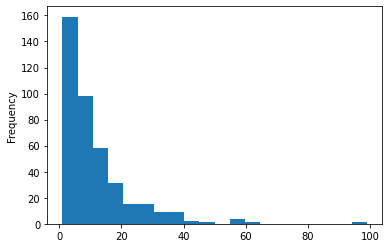

In [8]:
partial_exit_lag.plot.hist(bins=20)
_entry_table